In [143]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from ipywidgets import *
from IPython.display import display
 

In [144]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [145]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts=[], refPts=[], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [16,4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        ax1.axvline(pt, color = 'black')
        
    for pt in refPts:
        ax1.axvline(pt, color = 'Red')
    plt.show()


In [146]:
def plot_Results(df, df_clean, result_df, theftpts=[], refPts=[], xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    fig, axi = plt.subplots(4, 1)
    axi[0].plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    axi[0].set_title('Original FuelData vs Time')
    axi[0].set_xlabel('time')

    axi[1].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[1].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[1].set_ylabel('FuelVoltage', color='b')
    axi[1].tick_params('y', colors='b')
    if len(ylim1) != 0:
        axi[1].set_ylim(ylim1)

    ax2 = axi[1].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2) != 0:
        ax2.set_ylim(ylim2)
    if len(xlim) != 0:
        plt.xlim(xlim)
    axi[1].set_title('Cleaned Data')
        
    for pt in refPts:
        axi[1].axvline(pt, color = 'Red')
    
    
    
    axi[2].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[2].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[2].set_ylabel('FuelVoltage', color='b')
    axi[2].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[2].set_ylim(ylim1)

    ax2 = axi[2].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        axi[2].set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt, color = 'black')
        

    axi[3].plot(result_df.theft_index, result_df['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
    axi[3].set_title('Fuel/km Ratio at Predicted theft pts - ZOOMED')
    
    axi[3].set_xlabel('time index')
    
    fig.tight_layout()

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

In [147]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    dist = cleanDf.distance[i] - cleanDf.distance[0]
    while (i<len(cleanDf)) and (dist <= 5000): 
        df = 0
        dist = 0.001*(cleanDf.distance[i] - cleanDf.distance[0])
        print(dist)
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

    med = pd.Series(avgDT).median()
    mean = pd.Series(avgDT).mean()
    avg = pd.Series(avgDT)
    max_dCRate = avg.median()+ 3*(abs(avg - avg.median()).median())
        
    return pd.Series(avgDT), indexlst, 1000*max_dCRate


In [148]:
i=j=0
while (i<10) and j<3 :
    print (i,j)
    i+=1
    j+=1

0 0
1 1
2 2


In [149]:
#####################################################################
### Function to generate FuelMaxVoltage & FuelMinVoltage, to be sent
### to the main devices database for records.
def Gen_FuelMaxMin(df):
    df = dr.perform_PreFormating(df)
    dff, dff2 = dr.perform_postFormating(df)

    fmax = dff.fuelVoltage.max()
    fmin = dff.fuelVoltage.min()

    #df_clean = dc.Clean_NoiseData(dff, 6, fmax, fmin)

    return fmax, fmin

In [150]:
folderpath = r"H:\Analytics\FuelAnalysis\test2"
savePath = r"H:\Analytics\FuelAnalysis\results"
filepath = r""
df_list = []
filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=8)
for file in filesname:
    df = dr.read_SingleCSV(file)
    df_list.append(df)

ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) + "Preformatting Done")

    dff, dff2 = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff,dff2

def cleanDF(dff, fuelMax, fuelMin, neb_ds):
    df_clean = dc.Clean_NoiseData(dff, fuelMax, fuelMin, neb_ds)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean, fuelMax, fuelMin, neb_dst):
    theft_pts, refpts = dc.jump_point(df_clean, 0.01, fuelMax, fuelMin, neb_dst)
    print("Dataset_" + str(ctr + 1) + " Theft & Refuel points Indentified")
    return theft_pts, refpts

    

H:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042644259.csv
H:\Analytics\FuelAnalysis\test2\cordinates_007042647584.csv


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


H:\Analytics\FuelAnalysis\test2\cordinates_007042648443.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527256951.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527904085.csv
H:\Analytics\FuelAnalysis\test2\cordinates_008527948598.csv


In [151]:
#plotData_profiles(df)
df = df_list[1]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: str(x)[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


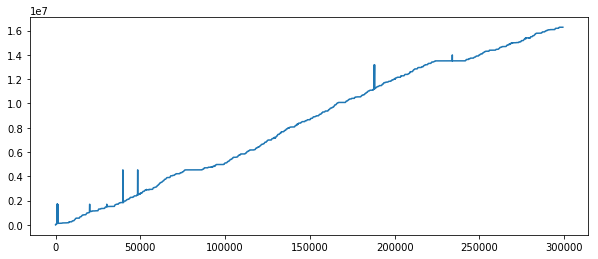

In [152]:
plt.rcParams['figure.figsize'] = [10,4]
plt.plot(dis);

In [153]:
fuelMax, fuelMin = Gen_FuelMaxMin(df)

2017-11-21 13:39:44
69350
2017-11-21 13:39:44
69350
66368
2017-11-30 17:42:33
Int64Index([16879, 53478, 53554], dtype='int64')
66367
2017-11-30 17:43:17
66367
2017-11-30 17:43:17
LenPostFormating:  66367


In [154]:
fuelMax, fuelMin

(534.0, 137.0)

In [155]:
dff, dff2 = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1Preformatting Done
2017-11-21 13:39:44
69350
2017-11-21 13:39:44
69350
66368
2017-11-30 17:42:33
Int64Index([16879, 53478, 53554], dtype='int64')
66367
2017-11-30 17:43:17
66367
2017-11-30 17:43:17
LenPostFormating:  66367
Dataset_1 Postformatting Done


In [156]:
df = dr.perform_PreFormating(df)

In [157]:
d = df[df.dev_state=='0']
len(d[d.fuelVoltage <= 5])

9184

In [158]:
len(df[df.dev_state=='0'])

229800

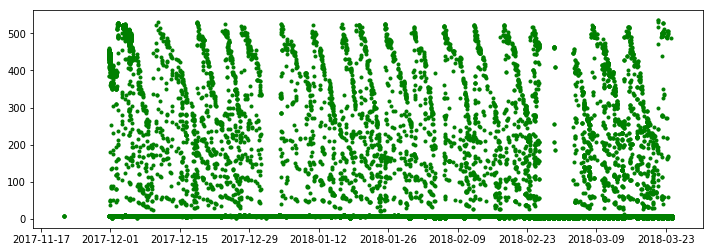

In [159]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(df[df.dev_state=='0'].datetime, df[df.dev_state=='0'].fuelVoltage, 'g.');
#plt.ylim(0,8)

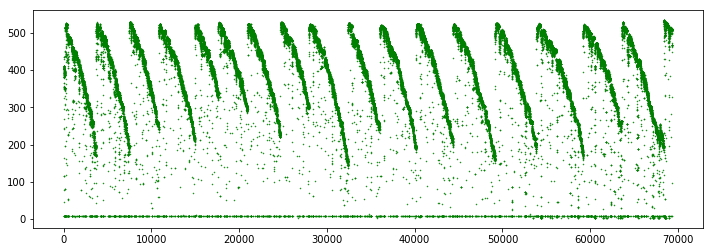

In [160]:
%matplotlib inline
df= df[df.dev_state=='1'].reset_index(drop = True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1);

In [161]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66367 entries, 0 to 66366
Data columns (total 7 columns):
datetime       66367 non-null datetime64[ns]
lat            66367 non-null object
long           66367 non-null object
speed          66367 non-null float64
distance       66367 non-null float64
fuelVoltage    66367 non-null float64
dev_state      66367 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 3.5+ MB


In [162]:
len(dff), len(dff2)

(66367, 69350)

In [163]:
a=[1,2,3,4,5,6]
a[0]

1

In [164]:
dff3 = dff2[dff2.fuelVoltage<=200]

In [165]:
dff.loc[0,'datetime'] - dff.loc[len(dff)-1,'datetime']

Timedelta('-114 days +14:59:24')

In [166]:
dff2.loc[0,'datetime'] - dff.loc[0,'datetime']

Timedelta('-1 days +23:59:16')

In [167]:
dff2.loc[0,'datetime'] - dff.datetime.min()

Timedelta('-1 days +23:59:16')

In [168]:
dff2.datetime[:10]

0   2017-11-30 17:42:33
1   2017-11-30 17:43:17
2   2017-11-30 17:43:46
3   2017-11-30 17:44:17
4   2017-11-30 17:44:24
5   2017-12-01 10:18:14
6   2017-12-01 10:18:44
7   2017-12-01 10:19:14
8   2017-12-01 10:19:45
9   2017-12-01 10:20:15
Name: datetime, dtype: datetime64[ns]

In [169]:

dff.datetime[0]

Timestamp('2017-11-30 17:43:17')

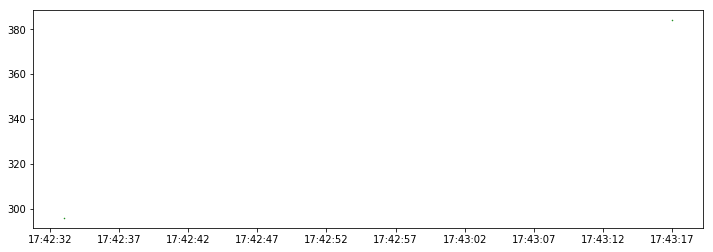

In [170]:
%matplotlib inline
dff2= dff2[dff2.dev_state==1].reset_index(drop=True)
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2[dff2.datetime<=dff.datetime.min()].datetime, dff2[dff2.datetime<=dff.datetime.min()].fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,20000)



3.0

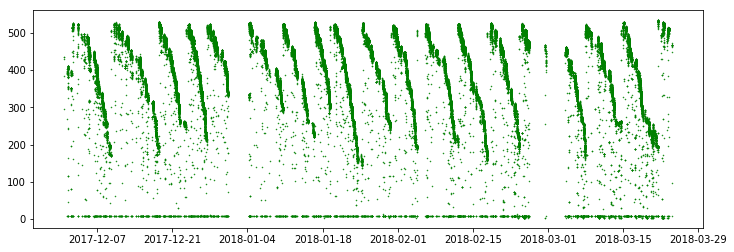

In [171]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(dff2.datetime, dff2.fuelVoltage,'g.', markersize = 1);
#plt.xlim(0,30000)
(dff3.fuelVoltage.min())


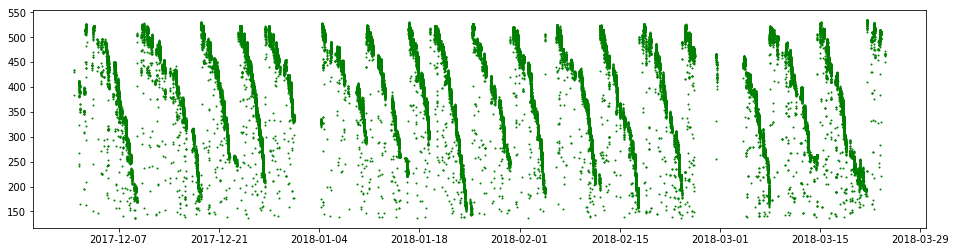

In [172]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.datetime, dff.fuelVoltage, 'g.', markersize = 2)
#plt.ylim(2,4)
#plt.xlim(32000,38000)

In [173]:
dff.fuelVoltage.median()

411.0

In [174]:
dff.fuelVoltage.std()

95.37034468997224

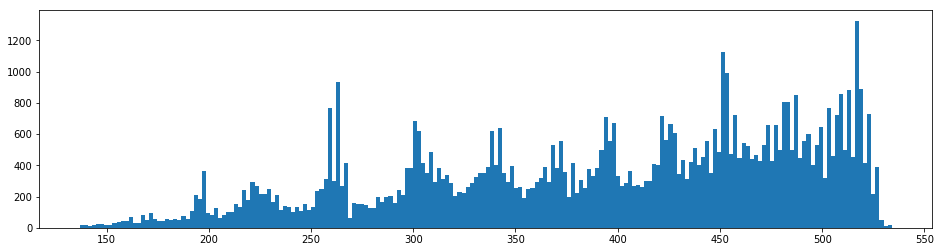

In [175]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

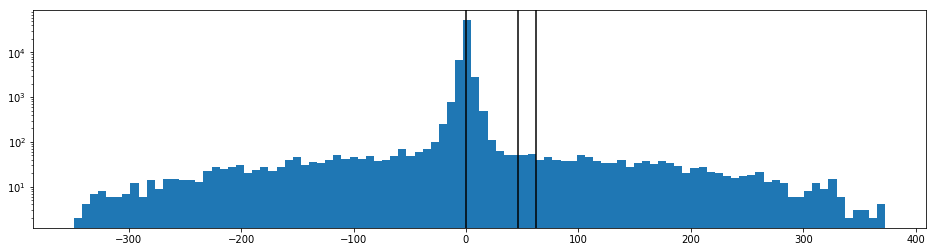

In [176]:
def avg_NeigbourDistance(dff):
    dd = dff.fuelVoltage - dff.fuelVoltage.shift(-1)  
    dd = dd.dropna()
    #print(dd)
    plt.hist(dd, bins=100)
    plt.axvline(dd.median(), color = 'black')
    plt.axvline(2*dd.std(), color = 'black')
    plt.axvline(1.5*dd.std(), color = 'black')
    plt.semilogy()
    return dd
dd = avg_NeigbourDistance(dff)

In [177]:
dd2 = dd[abs(dd - dd.median()) < 2*dd.std()]
meddev = abs(dd2 - dd2.median()).median()
meddev2 = abs(dd2 - dd2.median()).mean()
print (dd.mean(), dd.median(),2*meddev, 2*meddev2, 2*dd2.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax))

-0.001341048127053009 0.0 2.0 4.458896772290447 11.161647573636744 3.97 5.073


In [178]:
meddev,dd2.std()

(1.0, 5.580823786818372)

In [179]:
distDF = pd.DataFrame(columns=['mean','median','2*Meddev','2*std','MaxMin','MaxMin0'])
distDF.loc[0] = [dd.mean(), dd.median(),2*meddev, 2*dd.std(), 0.01*(fuelMax - fuelMin), 0.01*(fuelMax - 0.05*fuelMax)]
distDF

,mean,median,2*Meddev,2*std,MaxMin,MaxMin0
0,-0.001341,0.0,2.0,62.066733,3.97,5.073


In [180]:
np.array([abs(dd) <= 2*dd.std()]).mean()

0.970542145074285

In [181]:
x = '0'
x.zfill(8)
import time

In [182]:
def Clean_NoiseData2(dff, fuelMax, fuelMin, nds):
    x = pd.Series(dff.index)
    y = pd.Series(dff.fuelVoltage)
        
    ## Neighbourhood Distance
    Nds = 0.01*(fuelMax - fuelMin)
    if nds:
        Nds = nds
    print(Nds)

    
    dff['dd00000'] = abs(y - y.shift(6))
    dff['dd0000'] = abs(y - y.shift(5))
    dff['dd000'] = abs(y - y.shift(4))
    dff['dd00'] = abs(y - y.shift(3))
    dff['dd0'] = abs(y - y.shift(2))
    dff['dd1'] = abs(y - y.shift(1))
    dff['dd2'] = abs(y - y.shift(-1))
    dff['dd3'] = abs(y - y.shift(-2))
    dff['dd4'] = abs(y - y.shift(-3))
    dff['dd5'] = abs(y - y.shift(-4))
    dff['dd6'] = abs(y - y.shift(-5))
    dff['dd7'] = abs(y - y.shift(-6))
    dff['dd8'] = abs(y - y.shift(-7))
    
    dforward = pd.DataFrame()
    dbackward = pd.DataFrame()
    for i in range(1,10):
        dforward['d'+str(i)] = abs(y - y.shift(i))
        dbackward['d'+str(i)] = abs(y - y.shift(-1*i))
    dbackward = dbackward.fillna(0)
    dforward = dforward.fillna(0)
    
    dff2 = dff[(dforward.d1 <= Nds) & (dbackward.d1 <= Nds) & (dforward.d2 <= 2*Nds) & (dbackward.d2 <= 2*Nds) &
               (dforward.d3 <= 3*Nds) & (dbackward.d3 <= 3*Nds) & (dforward.d4 <= 4*Nds) & (dbackward.d4 <= 4*Nds) &
               (dforward.d5 <= 5*Nds) & (dbackward.d5 <= 5*Nds) & (dforward.d6 <= 6*Nds) & (dbackward.d6 <= 6*Nds) &
               (dforward.d7 <= 7*Nds) & (dbackward.d7 <= 7*Nds) & (dforward.d8 <= 8*Nds) & (dbackward.d8 <= 8*Nds)]
    dff2 = dff2.reset_index(drop = True)
    

    p = dff['dd1']
    ## Removing Error Data
    dff1 = dff[(dff.dd1 <= Nds) & (dff.dd2 <= Nds) & (dff.dd0 <= 2*Nds) & (dff.dd3 <= 2*Nds) &
               (dff.dd00 <= 3*Nds) & (dff.dd4 <= 3*Nds) & (dff.dd000 <= 4*Nds) & (dff.dd5 <= 4*Nds) &
               (dff.dd0000 <= 5*Nds) & (dff.dd6 <= 5*Nds) & (dff.dd00000 <= 6*Nds) & (dff.dd7 <= 6*Nds)]
    dff1 = dff1.reset_index(drop=True)  ## Reseting index
    #print (dff1[['dd1','dd0','dd00','dd000','dd0000','dd00000']].head(40))

    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(p, 'b.')
    # plt.title('Histogram - Consecutive Fuel Difference ', fontsize=15)
    # plt.ylim(0, 0.05)
    #
    # #     plt.ylim(0.02,1)
    # #     plt.savefig("test.png")
    # plt.rcParams['figure.figsize'] = [16, 4]
    # plt.plot(dff.index[:], dff.fuelVoltage[:], 'g.', markersize=2, linewidth=1);
    # plt.ylim(0, 1.1)
    dfClean = dff1[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean['fuelVoltage_Percent'] = dfClean.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))
    dfClean2 = dff2[['datetime','lat', 'long','speed','distance','fuelVoltage']]
    dfClean2['fuelVoltage_Percent'] = dfClean2.fuelVoltage.apply(lambda x: round((100*x/(fuelMax - fuelMin)),2))

    return dfClean, dfClean2

In [183]:
import time
strttime = time.time()
dfcln, dfcln2 = Clean_NoiseData2(dff.copy(), fuelMax, fuelMin,2*meddev)
print(time.time()-strttime)

2.0


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.6796536445617676


C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [184]:
y = pd.Series([1,2,3,4,5,6,7,8])
y.shift(-1) -y

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
dtype: float64

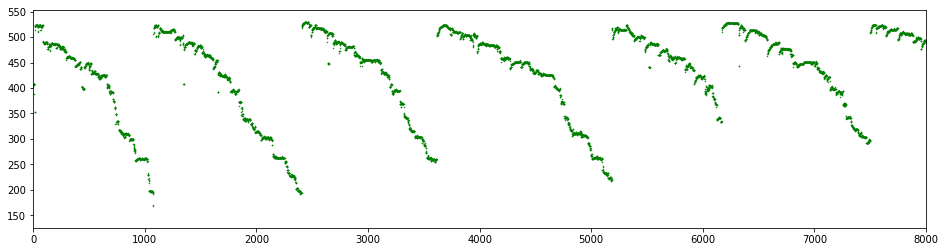

In [185]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dfcln2.index, dfcln2.fuelVoltage,  'g.', markersize = 1)
#plt.ylim(300,580)
plt.xlim(0,8000)
plt.savefig("cleanf22.png")

In [186]:
df_clean = dff

In [191]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
 
t = np.linspace(0,10,200) # create a time signal
x1 = np.sin(t) # create a simple sine wave
x2 = x1 + np.random.rand(200) # add noise to the signal

def f(x):
    y1 = sp.signal.medfilt(df_clean.fuelVoltage,x) # add noise to the signal
    # plot the results
    plt.subplot(2,1,1)
    plt.plot(df_clean.index,df_clean.fuelVoltage,'g.', markersize = 1)
    plt.title('input wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.subplot(2,1,2)
    plt.plot(df_clean.index,y1,'g.', markersize = 1)
    plt.title('filtered wave')
    plt.xlabel('time')
    plt.xlim(10000, 30000)
    plt.show()
interact(f, x= IntSlider(min=1, max=200, step=2,value=99));

interactive(children=(IntSlider(value=99, description='x', max=200, min=1, step=2), Output()), _dom_classes=('…

In [192]:
len(df_clean), len(y1)

(66367, 66367)

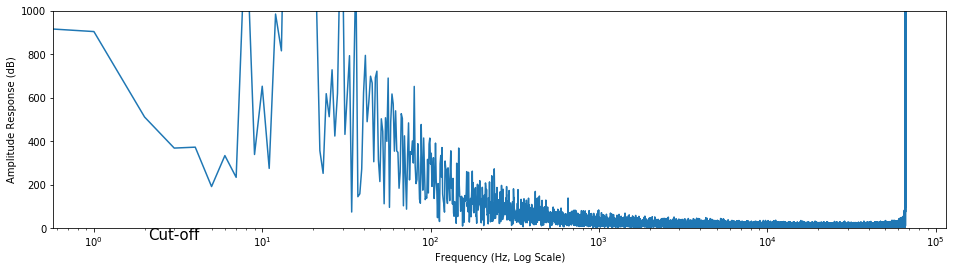

In [193]:
from scipy.fftpack import fft
from scipy import signal as sg
import statsmodels.api as sm
from scipy.signal import butter, lfilter, freqz
import datetime

normdata = df_clean.fuelVoltage/df_clean.fuelVoltage.max()
yvolt = fft(df_clean.fuelVoltage/df_clean.fuelVoltage.max())

plt.rcParams['figure.figsize'] = [16,4]
plt.ylim(0,1000);
plt.plot(np.abs(yvolt[:]));
plt.rcParams['figure.figsize'] = [16,4]
plt.xscale('log')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (Hz, Log Scale)')
#plt.axvline((2.5, color = 'black')
plt.text(2.1,-50, "Cut-off", fontsize = 15);

def butter_lowpass_filter(data, cutoff, fs, order=5, ftype = False):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=ftype)
    y = lfilter(b, a, data)
    y1 = sg.filtfilt(b,a, data)
    return y


# Filter the data, and plot both the original and filtered signals.
fs = 500             # Sampling Frequency
order = 5             # Order of Filter
cutoff = 10          # Filter Cut-off Frequency

df = df_clean.copy()
# Calling Butterworth filter
y2 = df_clean.fuelVoltage.max() *(butter_lowpass_filter(normdata, cutoff, fs, order, ftype= False))
time = df.datetime

(0, 12000)

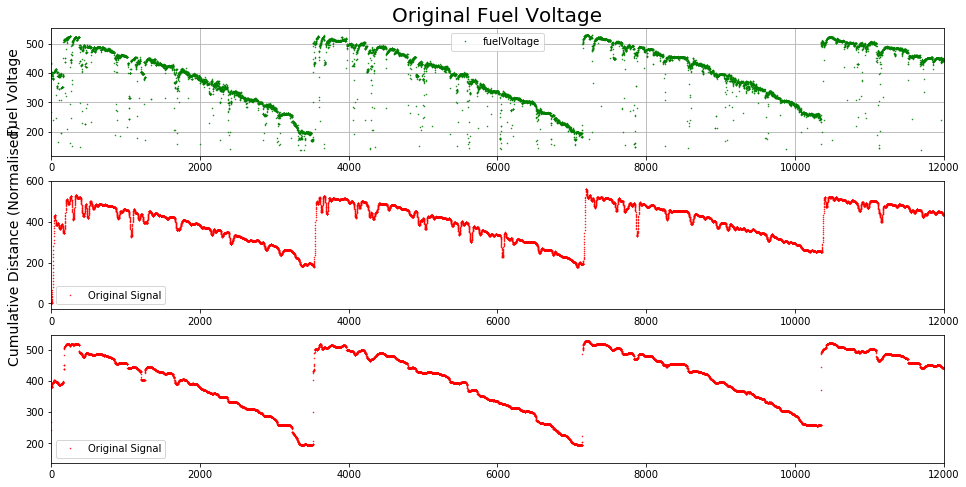

In [194]:
#Plotting Results
plt.rcParams['figure.figsize'] = [16,8]

plt.subplot(3, 1,1)
#plt.plot(time, norm_data, 'b-', linewidth=1, label='Original Signal')
plt.plot(df.index, df.fuelVoltage, 'g.', markersize = 1, linewidth = 1)
plt.legend()
plt.grid()
plt.ylabel('Fuel Voltage',  fontsize = 14)
plt.xlim(0,12000)
plt.title('Original Fuel Voltage', fontsize = 20)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
#plt.axvline(60000, color = 'black')

plt.subplot(3, 1,2)
plt.plot(df.index, y2, 'r.', markersize=1, label='Original Signal')
plt.legend()
plt.xlim(0,12000)
#plt.ylim(df_clean.fuelVoltage.min(), 1.05*df_clean.fuelVoltage.max())
plt.ylabel('Cumulative Distance (Normalised)',  fontsize = 14)
#plt.xlim(datetime.datetime(2018,1,27,2,0), datetime.datetime(2018,2,15,6,55))
plt.subplot(3, 1,3)
plt.plot(df_clean.index, y1, 'r.', markersize=1, label='Original Signal')
plt.legend()
plt.xlim(0,12000)

#plt.tight_layout()

In [ ]:
#df_clean = cleanDF(dff.copy(), fuelMax, fuelMin,0)

In [196]:
df_clean2 = dff.copy()
df_clean2.fuelVoltage = pd.Series(y1)

In [197]:
## Finding avgMax decay rate
avgDT, indexlst, max_dCRate = findMax_decayRate(df_clean2)

0.0
131.57
131.57
131.57
131.57
131.729
132.466
132.466
132.466
138.679
157.43200000000002
157.65
161.031
163.311
173.946
174.32500000000002
174.32500000000002
174.32500000000002
255.834
255.834
255.857
256.173
257.778
259.299
261.21
374.647
375.874
386.257
386.668
389.24
389.41
401.176
404.629
405.469
408.25
410.563
412.35
412.90000000000003
417.541
419.683
425.144
428.065
432.216
439.639
442.43600000000004
443.03700000000003
444.962
447.17400000000004
450.812
453.742
455.884
456.567
456.886
457.319
457.319
457.842
458.47200000000004
459.562
459.61400000000003
494.57
503.8
504.535
506.048
507.349
507.492
536.595
536.595
536.797
538.073
542.646
544.215
547.449
554.78
556.126
556.443
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
556.4590000000001
588.847
594.316
596.795
598.491
599.463
600.115
600.897
601.888
603.973
607.09
608.711
609.517
613.891
614.587
615.328
620.601
623.1370000000001
632.328
633.202
635.106
635.538
636.294
646.567
671.16
672.54
673.948
676

2890.543
2893.8940000000002
2907.368
2920.358
2964.485
2970.65
2973.0460000000003
2973.053
2986.6620000000003
2989.3
2990.108
2992.9900000000002
2995.215
2997.356
3019.28
3022.273
3024.266
3026.456
3026.908
3028.4
3029.776
3064.484
3065.735
3066.527
3067.885
3068.236
3068.741
3069.436
3070.4590000000003
3070.872
3071.179
3071.29
3071.571
3078.351
3078.827
3080.473
3082.17
3107.376
3108.341
3110.53
3112.9700000000003
3114.01
3115.035
3115.039
3115.039
3115.515
3115.59
3116.625
3117.186
3117.217
3149.256
3156.177
3159.02
3178.607
3180.483
3181.976
3183.785
3186.029
3186.607
3187.0480000000002
3187.4120000000003
3187.493
3187.626
3188.815
3189.289
3190.9210000000003
3192.123
3193.4790000000003
3193.495
3197.63
3208.742
3210.821
3228.724
3235.83
3237.918
3238.523
3240.123
3240.123
3240.381
3241.236
3241.712
3242.413
3289.625
3290.014
3323.684
3325.225
3326.393
3328.6910000000003
3330.414
3331.527
3333.05
3337.107
3338.099
3341.282
3342.439
3350.8450000000003
3371.627
3373.994
3377.465
3380

In [216]:
## Finding avgMax decay rate
avgDT2, indexlst2, max_dCRate2 = findMax_decayRate(dfcln2)

0.0
7.109
19.768
20.513
22.677
23.781
31.506
34.82
38.113
41.662
129.64000000000001
243.481
243.87900000000002
244.183
245.614
247.368
247.77100000000002
248.485
249.041
251.965
255.876
258.424
263.26800000000003
265.848
267.452
268.576
268.909
269.397
269.606
270.857
271.657
273.113
276.958
277.97
279.55
280.98
283.21500000000003
285.971
286.627
290.922
291.617
291.90000000000003
293.87
297.598
299.707
303.448
304.516
308.853
310.30400000000003
311.134
314.028
316.314
317.061
317.86
318.548
321.81
340.035
341.408
346.10200000000003
346.938
354.494
355.312
356.176
358.722
361.431
364.21
365.37
371.652
372.23
372.96500000000003
373.702
374.822
387.26300000000003
394.103
401.914
403.365
408.36
421.791
424.889
424.889
424.889
424.889
424.889
431.605
432.802
441.177
442.301
443.075
445.514
447.08500000000004
451.463
452.54900000000004
453.613
459.02
463.834
464.462
467.314
469.327
471.81
477.148
482.249
482.964
483.343
485.017
485.967
487.37
491.708
493.497
497.98400000000004
499.253
500.5

3352.765
3354.5460000000003
3355.241
3356.329
3357.3160000000003
3363.2980000000002
3363.982
3368.466
3369.444
3370.1530000000002
3371.9700000000003
3383.621
3399.881
3400.145
3403.857
3406.761
3407.734
3408.408
3422.023
3425.4320000000002
3476.261
3487.755
3493.292
3495.35
3501.244
3506.8360000000002
3513.4010000000003
3523.98
3526.603
3532.148
3536.2780000000002
3537.2110000000002
3541.37
3542.701
3544.8920000000003
3545.5860000000002
3548.253
3550.32
3556.219
3558.322
3558.742
3559.569
3560.86
3563.295
3563.648
3564.435
3566.271
3566.76
3568.7090000000003
3570.515
3571.611
3572.839
3574.044
3575.029
3578.949
3580.631
3585.241
3585.853
3586.216
3591.3340000000003
3592.88
3593.934
3596.248
3598.12
3606.157
3608.881
3610.679
3619.958
3629.859
3631.954
3641.887
3645.016
3651.608
3652.919
3661.118
3661.795
3670.524
3672.163
3672.9300000000003
3678.827
3679.419
3685.486
3686.804
3689.21
3691.9320000000002
3693.213
3694.202
3696.655
3697.676
3699.077
3713.808
3725.98
3728.176
3728.93200000

In [198]:
max_dCRate, avgDT.median(), round(avgDT.mean(),5)

(2.570056113467123, 0.0008087376367463173, 44.57503)

In [217]:
max_dCRate2, avgDT2.median(), round(avgDT2.mean(),5)

(2.3892695165492617, 0.0008298755186721991, 5.92327)

In [ ]:

a = int(-3)
if a:
    print (a)

In [ ]:
def jump_point2(dff,m, level = 0.05, fuelMax=100, fuelMin=0):
    x = np.array(dff.index)
    y = np.array(dff.fuelVoltage)
    d = np.array(dff.distance)
    
    #######################################################################
    ## No. of Neighbourhood pts , dependent on sampling Rate of IoT device
    ## Criteria Set = Avg No. of points inside 10Km window will be considered
    n = int(10000/(dff.distance.max()/len(dff)))
    
    level = level*(fuelMax - fuelMin)
    theft_pts = []
    refpts = []
    rctr = 0
    ctr = 0
    i = 0
    dd1 = [0]
    disback = []
    disfor = []

    dd2 = [y[1] - y[0]]
    for i in range(1, len(x)):
        try:
            #             d1 =abs(y[i+1] - y[i])
            #             d2 =abs(y[i+2] - y[i])
            d_forward = (y[i + 1:i + n] - y[i])
            d_backward = (y[i + 1] - y[i - n:i])
            disfor.append(d[i + n] - d[i])
            disback.append(d[i] - d[i-n])
            # print (d_backward)
            
        except:
            pass
            #print("**")
        # dd1.append(d1)
        # dd2.append(d2)
        # if (d1 >= 0.05) & (d2 >= 0.05)&(d3 >= 0.05)&(d4 >= 0.05)&(d5 >= 0.05)&(d5 >= 0.05):

        ###########################################################################
        #### Finding probable refueling Points
        if ((sum(d_forward > 1 * 3 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward > 1 * 3 * level) in list(range(n-1, n+1))):
                refpts.append(dff.index[i])
                rctr += 1

        ############################################################################
        #### Finding probable theft points
        if ((sum(d_forward < -1 * level) in list(range(n-1, n+1)))):  # & (sum(d_forward<0.1) == 19)):
            if (sum(d_backward < -1 * level) in list(range(n-1, n+1))):
                theft_pts.append(dff.index[i])
                ctr += 1
                # print(theft_pts, ctr)

        if (ctr >= 2):
            if ((theft_pts[ctr - 1] - theft_pts[ctr - 2]) in list(range(1, 6))):
                theft_pts.pop(ctr - 2)
                ctr -= 1
                # print (i)

                # dd1.append(0)
                # dd2.append(0)
    # dff['dd1'] = pd.Series(dd1)
    # dff['dd2'] = pd.Series(dd2)
    print(len(theft_pts))
    return theft_pts, refpts, disback, disfor

In [199]:
theft_pts, refpts = findtheft(df_clean2, fuelMax, fuelMin,0)

Points per 10Km:  40
91
Dataset_1 Theft & Refuel points Indentified


In [203]:
theft_pts2, refpts2 = findtheft(dfcln2, fuelMax, fuelMin,0)

Points per 10Km:  16
331
Dataset_1 Theft & Refuel points Indentified


In [ ]:
theft_pts, refpts

In [ ]:
dff2[dff2.datetime<=df_clean.datetime.min()]

In [202]:
int(10000/(df_clean.distance.max()/len(df_clean2)))

40

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


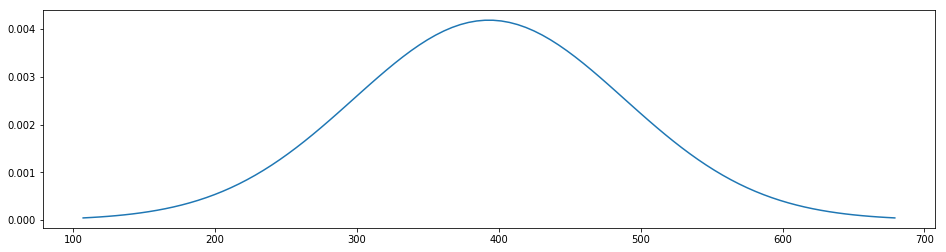

In [205]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(x,mlab.normpdf(x, mu, sigma))

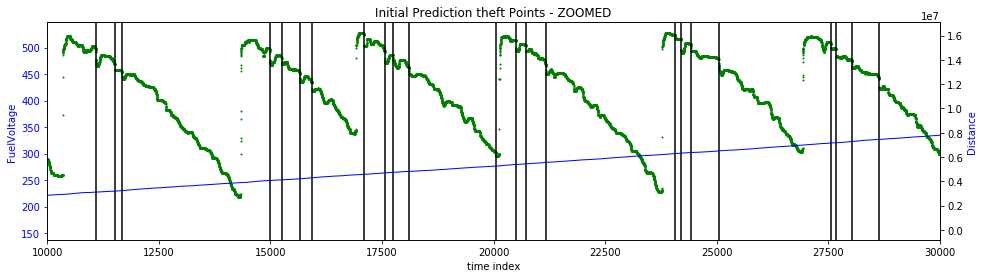

In [212]:
xlim = [10000,30000]
ylim = []
%matplotlib inline
plot_theftpts(df_clean2,refPts=[],theftpts=theft_pts,  xlim = xlim, ylim1= ylim)

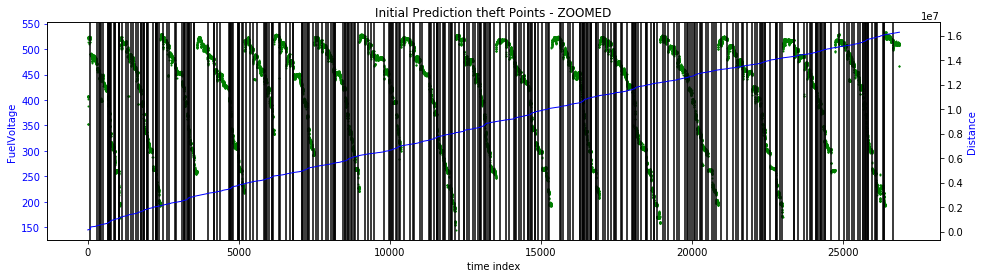

In [210]:
xlim = []
ylim = []
%matplotlib inline
plot_theftpts(dfcln2,refPts=[],theftpts=theft_pts2,  xlim = xlim, ylim1= ylim)

In [214]:
len(refpts), len(refpts2)

(65, 21)

In [215]:
df_clean.distance.max() - df_clean.distance[0] 

16277888.0

In [222]:
result_df2 = dc.generate_PredictTable(dfcln2,theft_pts2,max_dCRate2, fuelMax, fuelMin)

176


In [223]:
result_df = dc.generate_PredictTable(df_clean2,theft_pts,max_dCRate, fuelMax, fuelMin)

91


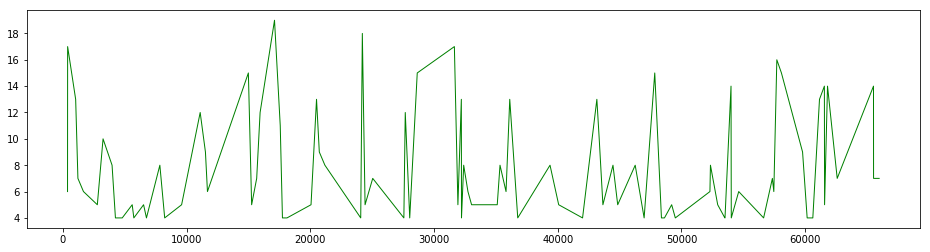

In [224]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df.theft_index, result_df['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

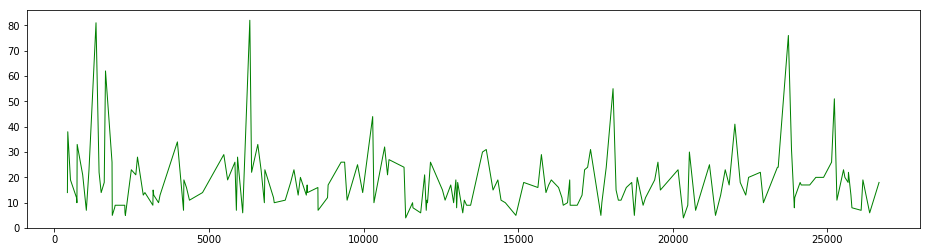

In [225]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df2.theft_index, result_df2['fuel_VoltageJump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

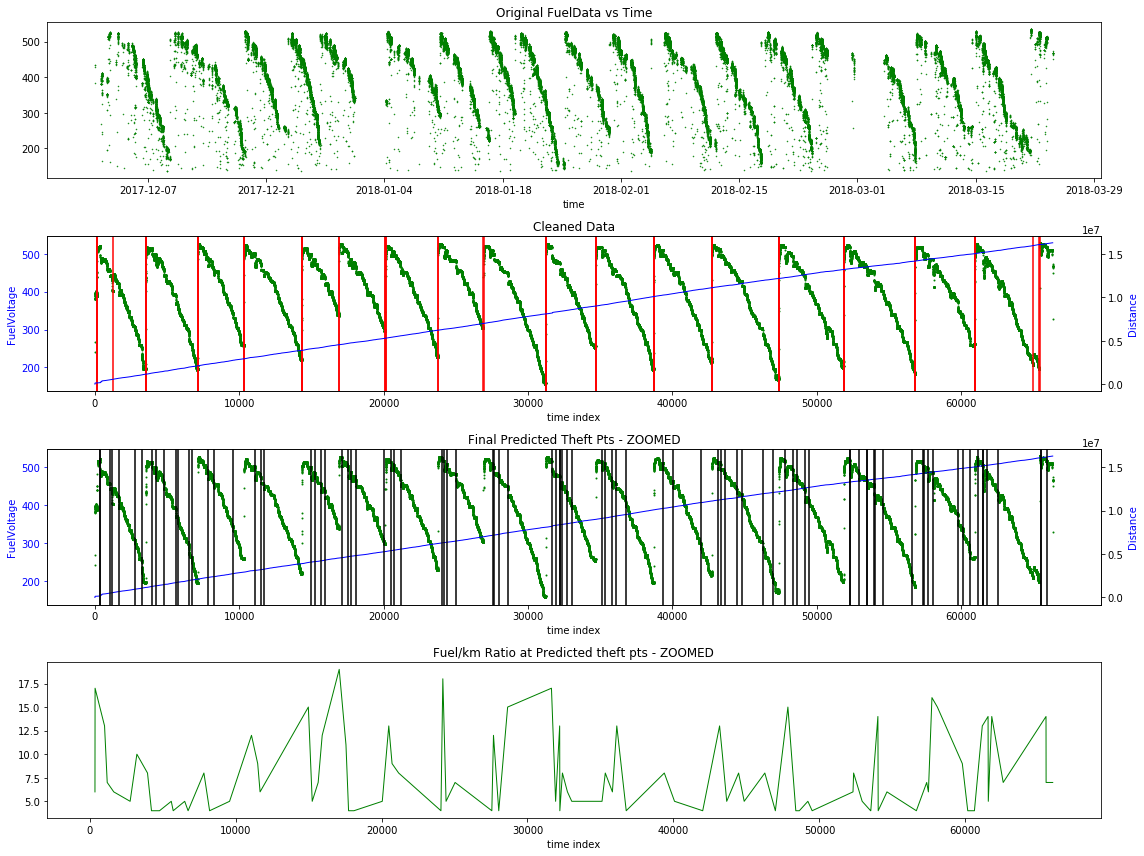

    theft_index                 lat               long          theft_time  fuel_VoltageJump  fuel_VoltageJump(%)  dist_jump(KM) time_jump  fuelVoltagePerKM
0           369          21.2780283  82.81943829999999 2017-12-03 12:17:49               6.0                 1.51          0.006  00:00:01       1000.000000
1           377  21.277279999999998          82.814555 2017-12-03 12:19:24              17.0                 4.28          0.006  10:24:15       2833.333333
2          1026  21.308178299999998         83.2782383 2017-12-05 11:26:32              13.0                 3.27          0.022  00:35:37        590.909091
3          1208          21.2787817           82.82519 2017-12-05 14:30:50               7.0                 1.76          0.000  00:01:00               inf
4          1657  21.608323300000002         82.0533867 2017-12-06 14:03:27               6.0                 1.51          0.015  00:00:30        400.000000
5          2778           21.412965         81.9110983 201

In [227]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean2, result_df, theft_pts, refpts , xlim = [], ylim1=ylim);
#ctr+=1
print(result_df)

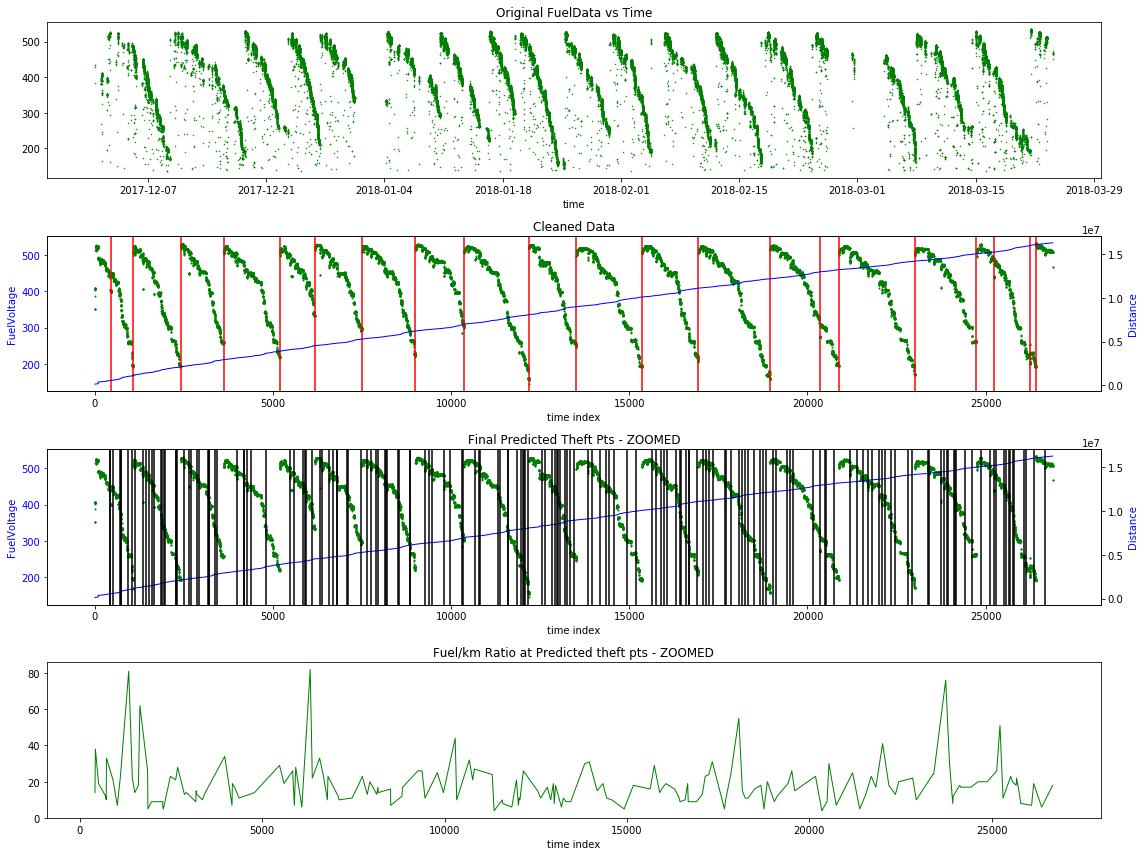

    theft_index                 lat               long          theft_time  fuel_VoltageJump  fuel_VoltageJump(%)  dist_jump(KM) time_jump  fuelVoltagePerKM
0           369          21.2780283  82.81943829999999 2017-12-03 12:17:49               6.0                 1.51          0.006  00:00:01       1000.000000
1           377  21.277279999999998          82.814555 2017-12-03 12:19:24              17.0                 4.28          0.006  10:24:15       2833.333333
2          1026  21.308178299999998         83.2782383 2017-12-05 11:26:32              13.0                 3.27          0.022  00:35:37        590.909091
3          1208          21.2787817           82.82519 2017-12-05 14:30:50               7.0                 1.76          0.000  00:01:00               inf
4          1657  21.608323300000002         82.0533867 2017-12-06 14:03:27               6.0                 1.51          0.015  00:00:30        400.000000
5          2778           21.412965         81.9110983 201

In [229]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,dfcln2, result_df2, theft_pts2, refpts2 , xlim = [], ylim1=ylim);
#ctr+=1
print(result_df)

In [ ]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.distance*0.001, df_clean.fuelVoltage, 'g.', markersize = 2)

In [ ]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dt = 10000
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    df1 = 0
    print(Dmax)
    while dt < 30000:
        avgDT = []
        indexlst = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            df1 = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df/ds
                    avgDT.append(avg)
                    indexlst.append(cleanDf.index[i])
            
            #print(df)
        indexlst_lst.append(indexlst)
        avgdt_lst.append(avgDT)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        ctr+=1
        dt += 1000
        print (dt)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT, avgLst, indexlst = findAVG(df_clean, Dmax)

In [ ]:
len(df_clean), len(avgLst), len(indexlst)

In [ ]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT[0]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT[0]).median() + 2*pd.Series(central_DT[0]).std(), color = 'Red')

#plt.ylim(0,.005)
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.ylim(0,.001)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

#plt.plot(central_DT[2]);

        

In [ ]:
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(avgLst[1],'b-');
plt.grid()
#plt.ylim(0,.4)

plt.axhline(pd.Series(avgLst[1]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[1]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[1]).std(), color = 'Red')
#plt.xlim(0,500)
plt.subplot(3,1,2)
plt.plot(avgLst[0], 'b-');
plt.axhline(pd.Series(avgLst[0]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[0]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[0]).std(), color = 'Red')

#plt.ylim(0,.4)
plt.grid()

In [ ]:
(indexlst[0])

In [ ]:
plt.hist(avgLst[1][abs(avgLst[1] - avgLst[1].mean()) < 3*avgLst[1].std()],bins = 200)
plt.axvline(avgLst[1].median(), color = 'black')
plt.axvline(avgLst[1].mean(), color = 'green')

In [ ]:

# w = IntSlider()
# display(w)
def f(x):
    return x
interact(f, x= IntSlider(min=-10, max=30, step=1,value=1));

In [ ]:
def f(x):    
    index = indexlst[x]
    avg = avgLst[x]
    plt.rcParams['figure.figsize'] = [16,4]
    plt.plot(index, avg, 'g.', markersize = 2)
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).mean(), color = 'blue')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.ylim(0,0.002)

interact(f, x= IntSlider(min=0, max=20, step=1,value=10));

In [ ]:
def findAVG2(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    dtmax = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/50
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    df1 = 0
    print(Dmax, dt, dtmax)
    while dt < dtmax:
        avgDT = []
        indexlst = []
        print ("dt = ",dt)
        i=0
        while i<len(cleanDf): 
            df = 0
            dfRef = cleanDf.fuelVoltage[i]
            dsRef = cleanDf.distance[i]
            while (df<=dt  and i<len(cleanDf)):
                df = dfRef - cleanDf.fuelVoltage[i] 
                if df <0 :
                    dfRef = cleanDf.fuelVoltage[i]
                i+=1
                #print(i)
            
            if i<len(cleanDf):
                ds = cleanDf.distance[i] - dsRef
                if df>0 :
                    #print (i)
                    if ds==0:
                        ds = df/1000
                        print("df = ",df,"****",i)
                    avg = df/ds
                    avgDT.append(avg)
                    indexlst.append(cleanDf.index[i])
            
        #print(avgDT)
        #print(dt)
        indexlst_lst.append(indexlst)
        if len(avgDT)!=0 :
            avgdt_lst.append(avgDT)
            med = pd.Series(avgDT).median()
            mean = pd.Series(avgDT).mean()
            #print (med,mean,mode)

            median_lst.append(med)
            mean_lst.append(mean)
        ctr+=1
        dt += dtmax/100
        #print (dt)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT2, avgLst2, indexlst2 = findAVG2(df_clean, Dmax)

In [ ]:
def findMax_decayRate(cleanDf):

    i = 0
    dt = (cleanDf.fuelVoltage.max() - cleanDf.fuelVoltage.min())/500
    avgDT = []
    indexlst = []
    
    while i<len(cleanDf): 
        df = 0
        dfRef = cleanDf.fuelVoltage[i]
        dsRef = cleanDf.distance[i]
        while (df<=dt  and i<len(cleanDf)):
            df = dfRef - cleanDf.fuelVoltage[i] 
            if df <0 :
                dfRef = cleanDf.fuelVoltage[i]
            i+=1
            #print(i)

        if i<len(cleanDf):
            ds = cleanDf.distance[i] - dsRef
            if df>0 :
                #print (i)
                if ds==0:
                    ds = df/1000
                    #print("df = ",df,"****",i)
                avg = df/ds
                avgDT.append(avg)
                indexlst.append(cleanDf.index[i])

        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        avg = pd.Series(avgDT)
        max_dCRate = avg.median()+ 3*abs(avg - avg.median()).median()
        
    return pd.Series(avgDT), indexlst, max_dCRate

avgDT, indexlst, max_dCRate = findMax_decayRate(df_clean)

In [ ]:
len(df_clean), len(avgDT), len(indexlst), max_dCRate

In [ ]:
sum(avgDT==1000)

In [ ]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT2[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT2[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT2[0]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT2[0]).median() + 2*pd.Series(central_DT2[0]).std(), color = 'Red')
plt.title('Histogram plot for Average Median for Varying Windows size')

plt.subplot(3,1,2)
plt.hist(central_DT2[1],bins =1000);
plt.grid()
plt.axvline(pd.Series(central_DT2[1]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT2[1]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT2[1]).median() + 2*pd.Series(central_DT2[1]).std(), color = 'Red')
plt.semilogx()
plt.semilogy()
plt.ylim(0,5000)
plt.title('Average Mean plot for Varying Windows size')

plt.subplot(3,1,3)
plt.plot(central_DT2[0]);
#plt.ylim(0,.002)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

In [ ]:
def f2(x):
    return x
def f(x):    
    index = indexlst2[x]
    avg = avgLst2[x]
    avg = pd.Series(avg)
    plt.rcParams['figure.figsize'] = [16,8]
    interact(f2, x=str(pd.Series(avg).median()));
    interact(f2, x=str(pd.Series(avg).median()+ 3*abs(avg - avg.median()).median()));
    plt.subplot(2,1,1)
    plt.plot(index, avg, 'g.')
    plt.semilogy()
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.axhline(pd.Series(avg).median()+ 4*abs(avg - avg.median()).median(), color = 'Blue')
    plt.axhline(pd.Series(avg).median()- 2*abs(avg - avg.median()).median(), color = 'Blue')
    abs(avg - avg.median()).median()
   # plt.ylim(0,0.05)
    plt.subplot(2,1,2)
    plt.plot(index,avg)
    plt.semilogy()
    plt.semilogx()
    #plt.ylim(0,0.1)
    #plt.axhline(pd.Series(avg).median(), color = 'red')
   # plt.axhline(pd.Series(avg).mean(), color = 'blue')
   ## plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    
    
interact(f, x= IntSlider(min=0, max=200, step=1,value=0));


In [ ]:
IntProgress(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

In [ ]:
 avg = pd.Series(avgLst2[0])
abs(avg - avg.median()).median()

In [ ]:
avg[avg!=1000].median(), avg[avg!=1000].std()

In [ ]:
meddev = []
for  avg in avgLst2:
    avg = pd.Series(avg)
    meddev.append(pd.Series(avg).median()+ 2*abs(avg - avg.median()).median())
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(meddev)
plt.axhline(pd.Series(meddev).median(), color = 'red')
plt.axhline(pd.Series(meddev).mean(), color = 'Black')
plt.xlim(0,100)

In [ ]:
pd.Series(meddev).mean(), max(meddev)

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')

In [231]:
from numpy import arange, sin, pi, float, size

import matplotlib
matplotlib.use('WXAgg')
from matplotlib.backends.backend_wxagg import FigureCanvasWxAgg
from matplotlib.figure import Figure

import wxpython as wx

class MyFrame(wx.Frame):
    def __init__(self, parent, id):
        wx.Frame.__init__(self,parent, id, 'scrollable plot',
                style=wx.DEFAULT_FRAME_STYLE ^ wx.RESIZE_BORDER,
                size=(800, 400))
        self.panel = wx.Panel(self, -1)

        self.fig = Figure((5, 4), 75)
        self.canvas = FigureCanvasWxAgg(self.panel, -1, self.fig)
        self.scroll_range = 400
        self.canvas.SetScrollbar(wx.HORIZONTAL, 0, 5,
                                 self.scroll_range)

        sizer = wx.BoxSizer(wx.VERTICAL)
        sizer.Add(self.canvas, -1, wx.EXPAND)

        self.panel.SetSizer(sizer)
        self.panel.Fit()

        self.init_data()
        self.init_plot()

        self.canvas.Bind(wx.EVT_SCROLLWIN, self.OnScrollEvt)

    def init_data(self):

        # Generate some data to plot:
        self.dt = 0.01
        self.t = arange(0,5,self.dt)
        self.x = sin(2*pi*self.t)

        # Extents of data sequence: 
        self.i_min = 0
        self.i_max = len(self.t)

        # Size of plot window:       
        self.i_window = 100

        # Indices of data interval to be plotted:
        self.i_start = 0
        self.i_end = self.i_start + self.i_window

    def init_plot(self):
        self.axes = self.fig.add_subplot(111)
        self.plot_data = \
                  self.axes.plot(self.t[self.i_start:self.i_end],
                                 self.x[self.i_start:self.i_end])[0]

    def draw_plot(self):

        # Update data in plot:
        self.plot_data.set_xdata(self.t[self.i_start:self.i_end])
        self.plot_data.set_ydata(self.x[self.i_start:self.i_end])

        # Adjust plot limits:
        self.axes.set_xlim((min(self.t[self.i_start:self.i_end]),
                           max(self.t[self.i_start:self.i_end])))
        self.axes.set_ylim((min(self.x[self.i_start:self.i_end]),
                            max(self.x[self.i_start:self.i_end])))

        # Redraw:                  
        self.canvas.draw()

    def OnScrollEvt(self, event):

     # Update the indices of the plot:
        self.i_start = self.i_min + event.GetPosition()
        self.i_end = self.i_min + self.i_window + event.GetPosition()
        self.draw_plot()

class MyApp(wx.App):
    def OnInit(self):
        self.frame = MyFrame(parent=None,id=-1)
        self.frame.Show()
        self.SetTopWindow(self.frame)
        return True

if __name__ == '__main__':
    app = MyApp()
    app.MainLoop()

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_inst

ModuleNotFoundError: No module named 'wxpython'